# Molecular Classifier

Source:
+ CLEF 2016,2013 


### 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [16]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor,ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [17]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/molecular_dataset.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH
NAME_OUTPUT  = 'molecular_v1'

My base path is /mnt
The given dataset is located here: ../data/molecular_dataset.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [18]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Molecular'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
MODE           = 'min'
EXTENSION      = '.pt'
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Molecular to save our sweep iterations


In [19]:
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier only with the class "Molecular"

In [20]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_molecular,dict_label = label_encoder_target(df,target_col='modality')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,1423-0127-16-109-3-1.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-16-109-3-1.jpg,MOLECULAR,A. Three dimensional model of class C protein ...,VAL
1,1423-0127-16-109-3-2.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-16-109-3-2.jpg,MOLECULAR,A. Three dimensional model of class C protein ...,TRAIN
2,1423-0127-17-34-3-1.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-1.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,TRAIN
3,1423-0127-17-34-3-2.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-2.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,VAL
4,1423-0127-17-34-3-3.jpg,D3DR,TRAIN,clef16,2016/train/D3DR/1423-0127-17-34-3-3.jpg,MOLECULAR,Three domains of AAG A (or C)-chain: (a) domai...,TRAIN


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


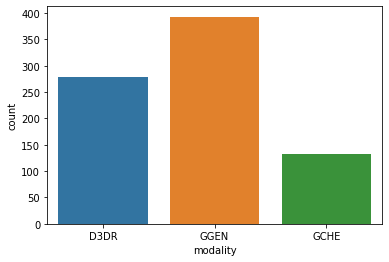

In [21]:
sns.countplot(df['modality'])
plt.show()

In [22]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_molecular,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=72)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.8519, 0.8512, 0.8414])
Std :  tensor([0.2773, 0.2772, 0.2900])


### 4. Sweep Running
+ First We will define the image transformations that we are goint to use for the training , evaluation and test

In [23]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [24]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Molecular
Metric Monitor: val_avg_loss


### 4.1 ResnetClassifier

In [25]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [0.00001]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet101"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [16]
            
        }
      
    }
}

In [26]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: bqj9irm0
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Molecular/sweeps/bqj9irm0


In [27]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)
print(OUTPUT_SWEEP)

/mnt/artifacts/experiments/Biomedical-Image-Classification-Molecular/bqj9irm0


In [28]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_molecular,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = NUM_WORKERS,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode=MODE
    )
    
    checkpoint_callback = ModelCheckpoint(dirpath    = output_run_path,
                                          filename   = NAME_OUTPUT,
                                          monitor    = METRIC_MONITOR,
                                          mode       = MODE,
                                          save_top_k = 1)
    checkpoint_callback.FILE_EXTENSION = EXTENSION
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = MODE,
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor,checkpoint_callback],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    del model
    
    model = ResNetClass.load_from_checkpoint(output_run_path/(NAME_OUTPUT + EXTENSION))
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer
    torch.cuda.empty_cache() 
    wandb.finish()

wandb: Agent Starting Run: w13yic0l with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-05
wandb: 	name: resnet101
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: feasible-sweep-1
Num_Classes 3


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 42.5 M
---------------------------------
42.5 M    Trainable params
0         Non-trainable params
42.5 M    Total params


Epoch    22: reducing learning rate of group 0 to 1.0000e-06.


wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).


Accuracy: 99.08256530761719
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        36
         1.0       1.00      0.96      0.98        28
         2.0       0.98      1.00      0.99        45

    accuracy                           0.99       109
   macro avg       0.99      0.99      0.99       109
weighted avg       0.99      0.99      0.99       109


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9880952380952381,
 'Macro F1-Score': 0.9902763902763904,
 'Macro Precision': 0.9927536231884058,
 'Macro Recall': 0.9880952380952381,
 'test_acc': tensor(99.0826, device='cuda:0'),
 'test_loss': tensor(0.0383, device='cuda:0')}
--------------------------------------------------------------------------------


lr-Adam,0.0
_step,1287
_runtime,387
_timestamp,1615864966
val_acc,99.08257
val_avg_loss,0.03862
epoch,22
train_acc,99.77064
train_avg_loss,0.02352
test_acc,99.08257
test_loss,0.0383


lr-Adam,██████████████████████▁
_step,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄█
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
val_acc,▁▆▇▆▇▇██▇▇▇▇███▇███████
val_avg_loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███
train_acc,▁▆▇▇▇██████████████████
train_avg_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_acc,▁
test_loss,▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


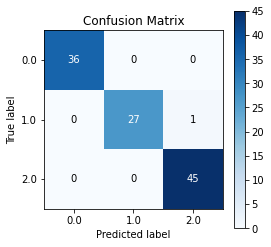

In [29]:
wandb.agent(sweep_id, function=sweep_iteration);

In [31]:
cp /mnt/artifacts/experiments/Biomedical-Image-Classification-Molecular/bqj9irm0/feasible-sweep-1/molecular_v1.pt /mnt/artifacts/models/Molecular

## 5.Testing 

In [33]:
 # setup data
model_path = '/mnt/artifacts/models/Molecular/molecular_v1.pt'
dm = ImageDataModule( batch_size       = 16,
                      label_encoder    = le_encoder_molecular,
                      data_path        = str(DATA_PATH), 
                      base_img_dir     = str(BASE_IMG_DIR),
                      seed             = SEED,   
                      image_transforms = [train_transform,val_transform,test_transform],
                      num_workers      = NUM_WORKERS,
                      target_class_col ='split_set',
                      modality_col     ='modality',
                      path_col         ='img_path')
dm.prepare_data()
dm.setup()
dm.set_seed()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 96.15384674072266
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95        96
         1.0       0.70      1.00      0.82        14
         2.0       0.98      0.99      0.98       150

    accuracy                           0.96       260
   macro avg       0.89      0.97      0.92       260
weighted avg       0.97      0.96      0.96       260


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9677777777777777,
 'Macro F1-Score': 0.9194231558116647,
 'Macro Precision': 0.8896321650916487,
 'Macro Recall': 0.9677777777777777,
 'test_acc': tensor(96.1538, device='cuda:0'),
 'test_loss': tensor(0.1248, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc': 96.15384674072266,
  'test_loss': 0.12475661933422089,
  'Macro F1-Score': 0.9194231558116647,
  'Balanced Accuracy': 0.9677777777777777,
  'Macro Recall': 0.9677777777777777,
  'Macro Precision': 0.8896321650916487}]

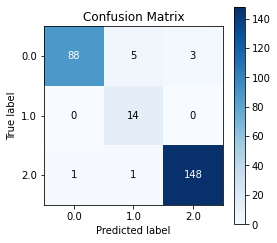

In [34]:
model = ResNetClass.load_from_checkpoint(model_path)
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=dm.test_dataloader())